<a href="https://colab.research.google.com/github/ShounakDas101/AIML_Hari/blob/main/ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import pandas as pd
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import random
import timeit
from tqdm import tqdm

In [9]:
RANDOM_SEED = 42
BATCH_SIZE = 512
EPOCHS = 40
LEARNING_RATE = 1e-4
NUM_CLASSES = 10
PATCH_SIZE = 4
IMG_SIZE = 28
IN_CHANNELS = 1
NUM_HEADS = 8
DROPOUT = 0.001
HIDDEN_DIM = 768
ADAM_WEIGHT_DECAY = 0
ADAM_BETAS = (0.9, 0.999)
ACTIVATION="gelu"
NUM_ENCODERS = 4
EMBED_DIM = (PATCH_SIZE ** 2) * IN_CHANNELS # 16
NUM_PATCHES = (IMG_SIZE // PATCH_SIZE) ** 2 # 49

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
class PatchEmbedding(nn.Module):
    def __init__(self, embed_dim, patch_size, num_patches, dropout, in_channels):
        super().__init__()
        self.patcher = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=embed_dim,
                kernel_size=patch_size,
                stride=patch_size,
            ),
            nn.Flatten(2))

        self.cls_token = nn.Parameter(torch.randn(size=(1, in_channels, embed_dim)), requires_grad=True)
        self.position_embeddings = nn.Parameter(torch.randn(size=(1, num_patches+1, embed_dim)), requires_grad=True)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        cls_token = self.cls_token.expand(x.shape[0], -1, -1)

        x = self.patcher(x).permute(0, 2, 1)
        x = torch.cat([cls_token, x], dim=1)
        x = self.position_embeddings + x
        x = self.dropout(x)
        return x

model = PatchEmbedding(EMBED_DIM, PATCH_SIZE, NUM_PATCHES, DROPOUT, IN_CHANNELS).to(device)
x = torch.randn(512, 1, 28, 28).to(device)
print(model(x).shape)

torch.Size([512, 50, 16])


In [6]:
class ViT(nn.Module):
    def __init__(self, num_patches, img_size, num_classes, patch_size, embed_dim, num_encoders, num_heads, hidden_dim, dropout, activation, in_channels):
        super().__init__()
        self.embeddings_block = PatchEmbedding(embed_dim, patch_size, num_patches, dropout, in_channels)

        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dropout=dropout, activation=activation, batch_first=True, norm_first=True)
        self.encoder_blocks = nn.TransformerEncoder(encoder_layer, num_layers=num_encoders)

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(normalized_shape=embed_dim),
            nn.Linear(in_features=embed_dim, out_features=num_classes)
        )

    def forward(self, x):
        x = self.embeddings_block(x)
        x = self.encoder_blocks(x)
        x = self.mlp_head(x[:, 0, :])  # Apply MLP on the CLS token only
        return x

model = ViT(NUM_PATCHES, IMG_SIZE, NUM_CLASSES, PATCH_SIZE, EMBED_DIM, NUM_ENCODERS, NUM_HEADS, HIDDEN_DIM, DROPOUT, ACTIVATION, IN_CHANNELS).to(device)
x = torch.randn(512, 1, 28, 28).to(device)
print(model(x).shape) # BATCH_SIZE X NUM_CLASSES

torch.Size([512, 10])


In [8]:
import os
from google.colab import drive
drive.mount('/content/drive')
# Specify the path to the file in your Google Drive
file_path = '/content/drive/MyDrive/digit-recognizer'

if os.path.exists(file_path):
    print(f"The file '{file_path}' exists in your Google Drive.")
else:
    print(f"The file '{file_path}' does not exist in your Google Drive.")

Mounted at /content/drive
The file '/content/drive/MyDrive/digit-recognizer' exists in your Google Drive.


In [11]:
train_df = pd.read_csv("/content/drive/MyDrive/digit-recognizer/train.csv")
test_df = pd.read_csv("/content/drive/MyDrive/digit-recognizer/test.csv")
submission_df = pd.read_csv("/content/drive/MyDrive/digit-recognizer/sample_submission.csv")

In [12]:
train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
test_df.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
submission_df.head()

,ImageId,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [15]:
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=RANDOM_SEED, shuffle=True)

In [16]:
class MNISTTrainDataset(Dataset):
    def __init__(self, images, labels, indicies):
        self.images = images
        self.labels = labels
        self.indicies = indicies
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomRotation(15),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx].reshape((28, 28)).astype(np.uint8)
        label = self.labels[idx]
        index = self.indicies[idx]
        image = self.transform(image)

        return {"image": image, "label": label, "index": index}

class MNISTValDataset(Dataset):
    def __init__(self, images, labels, indicies):
        self.images = images
        self.labels = labels
        self.indicies = indicies
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx].reshape((28, 28)).astype(np.uint8)
        label = self.labels[idx]
        index = self.indicies[idx]
        image = self.transform(image)

        return {"image": image, "label": label, "index": index}

class MNISTSubmitDataset(Dataset):
    def __init__(self, images, indicies):
        self.images = images
        self.indicies = indicies
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx].reshape((28, 28)).astype(np.uint8)
        index = self.indicies[idx]
        image = self.transform(image)

        return {"image": image, "index": index}

37800
{'image': tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0

<Figure size 640x480 with 0 Axes>

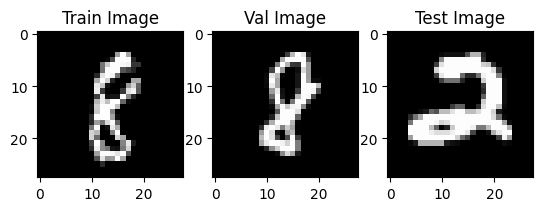

In [17]:
plt.figure()
f, axarr = plt.subplots(1, 3)

train_dataset = MNISTTrainDataset(train_df.iloc[:, 1:].values.astype(np.uint8), train_df.iloc[:, 0].values, train_df.index.values)
print(len(train_dataset))
print(train_dataset[0])
axarr[0].imshow(train_dataset[0]["image"].squeeze(), cmap="gray")
axarr[0].set_title("Train Image")
print("-"*30)

val_dataset = MNISTValDataset(val_df.iloc[:, 1:].values.astype(np.uint8), val_df.iloc[:, 0].values, val_df.index.values)
print(len(val_dataset))
print(val_dataset[0])
axarr[1].imshow(val_dataset[0]["image"].squeeze(), cmap="gray")
axarr[1].set_title("Val Image")
print("-"*30)

test_dataset = MNISTSubmitDataset(test_df.values.astype(np.uint8), test_df.index.values)
print(len(test_dataset))
print(test_dataset[0])
axarr[2].imshow(test_dataset[0]["image"].squeeze(), cmap="gray")
axarr[2].set_title("Test Image")
print("-"*30)

plt.show()

In [18]:
train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

val_dataloader = DataLoader(dataset=val_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=True)

test_dataloader = DataLoader(dataset=test_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), betas=ADAM_BETAS, lr=LEARNING_RATE, weight_decay=ADAM_WEIGHT_DECAY)

start = timeit.default_timer()
for epoch in tqdm(range(EPOCHS), position=0, leave=True):
    model.train()
    train_labels = []
    train_preds = []
    train_running_loss = 0
    for idx, img_label in enumerate(tqdm(train_dataloader, position=0, leave=True)):
        img = img_label["image"].float().to(device)
        label = img_label["label"].type(torch.uint8).to(device)
        y_pred = model(img)
        y_pred_label = torch.argmax(y_pred, dim=1)

        train_labels.extend(label.cpu().detach())
        train_preds.extend(y_pred_label.cpu().detach())

        loss = criterion(y_pred, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_running_loss += loss.item()
    train_loss = train_running_loss / (idx + 1)

    model.eval()
    val_labels = []
    val_preds = []
    val_running_loss = 0
    with torch.no_grad():
        for idx, img_label in enumerate(tqdm(val_dataloader, position=0, leave=True)):
            img = img_label["image"].float().to(device)
            label = img_label["label"].type(torch.uint8).to(device)
            y_pred = model(img)
            y_pred_label = torch.argmax(y_pred, dim=1)

            val_labels.extend(label.cpu().detach())
            val_preds.extend(y_pred_label.cpu().detach())

            loss = criterion(y_pred, label)
            val_running_loss += loss.item()
    val_loss = val_running_loss / (idx + 1)

    print("-"*30)
    print(f"Train Loss EPOCH {epoch+1}: {train_loss:.4f}")
    print(f"Valid Loss EPOCH {epoch+1}: {val_loss:.4f}")
    print(f"Train Accuracy EPOCH {epoch+1}: {sum(1 for x,y in zip(train_preds, train_labels) if x == y) / len(train_labels):.4f}")
    print(f"Valid Accuracy EPOCH {epoch+1}: {sum(1 for x,y in zip(val_preds, val_labels) if x == y) / len(val_labels):.4f}")
    print("-"*30)

stop = timeit.default_timer()
print(f"Training Time: {stop-start:.2f}s")

100%|██████████| 9/9 [00:00<00:00, 12.87it/s]


------------------------------
Train Loss EPOCH 1: 2.3060
Valid Loss EPOCH 1: 2.2698


  2%|▎         | 1/40 [00:22<14:34, 22.42s/it]

Train Accuracy EPOCH 1: 0.1407
Valid Accuracy EPOCH 1: 0.1531
------------------------------


100%|██████████| 9/9 [00:00<00:00,  9.33it/s]


------------------------------
Train Loss EPOCH 2: 2.0345
Valid Loss EPOCH 2: 1.7447


  5%|▌         | 2/40 [00:43<13:48, 21.80s/it]

Train Accuracy EPOCH 2: 0.2590
Valid Accuracy EPOCH 2: 0.3993
------------------------------


100%|██████████| 9/9 [00:00<00:00, 12.07it/s]


------------------------------
Train Loss EPOCH 3: 1.6484
Valid Loss EPOCH 3: 1.4727
Train Accuracy EPOCH 3: 0.4350


  8%|▊         | 3/40 [01:05<13:16, 21.54s/it]

Valid Accuracy EPOCH 3: 0.5195
------------------------------


100%|██████████| 9/9 [00:00<00:00, 10.07it/s]


------------------------------
Train Loss EPOCH 4: 1.4397
Valid Loss EPOCH 4: 1.2749
Train Accuracy EPOCH 4: 0.5453


 10%|█         | 4/40 [01:26<13:00, 21.67s/it]

Valid Accuracy EPOCH 4: 0.6448
------------------------------


100%|██████████| 9/9 [00:00<00:00, 12.14it/s]


------------------------------
Train Loss EPOCH 5: 1.2848
Valid Loss EPOCH 5: 1.1505


 12%|█▎        | 5/40 [01:47<12:31, 21.47s/it]

Train Accuracy EPOCH 5: 0.6279
Valid Accuracy EPOCH 5: 0.6838
------------------------------


100%|██████████| 9/9 [00:00<00:00, 12.27it/s]


------------------------------
Train Loss EPOCH 6: 1.1726
Valid Loss EPOCH 6: 1.0583


 15%|█▌        | 6/40 [02:09<12:14, 21.61s/it]

Train Accuracy EPOCH 6: 0.6755
Valid Accuracy EPOCH 6: 0.7357
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.78it/s]


------------------------------
Train Loss EPOCH 7: 1.0833
Valid Loss EPOCH 7: 0.9729


 18%|█▊        | 7/40 [02:31<11:48, 21.47s/it]

Train Accuracy EPOCH 7: 0.7086
Valid Accuracy EPOCH 7: 0.7521
------------------------------


100%|██████████| 9/9 [00:00<00:00, 12.35it/s]


------------------------------
Train Loss EPOCH 8: 1.0012
Valid Loss EPOCH 8: 0.9080


 20%|██        | 8/40 [02:52<11:28, 21.50s/it]

Train Accuracy EPOCH 8: 0.7362
Valid Accuracy EPOCH 8: 0.7971
------------------------------


100%|██████████| 9/9 [00:00<00:00,  9.51it/s]


------------------------------
Train Loss EPOCH 9: 0.9335
Valid Loss EPOCH 9: 0.8263


 22%|██▎       | 9/40 [03:14<11:06, 21.51s/it]

Train Accuracy EPOCH 9: 0.7608
Valid Accuracy EPOCH 9: 0.8014
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.66it/s]


------------------------------
Train Loss EPOCH 10: 0.8757
Valid Loss EPOCH 10: 0.7919


 25%|██▌       | 10/40 [03:35<10:43, 21.46s/it]

Train Accuracy EPOCH 10: 0.7742
Valid Accuracy EPOCH 10: 0.8155
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.91it/s]


------------------------------
Train Loss EPOCH 11: 0.8216
Valid Loss EPOCH 11: 0.7189


 28%|██▊       | 11/40 [03:57<10:22, 21.48s/it]

Train Accuracy EPOCH 11: 0.7915
Valid Accuracy EPOCH 11: 0.8379
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.75it/s]


------------------------------
Train Loss EPOCH 12: 0.7808
Valid Loss EPOCH 12: 0.6859
Train Accuracy EPOCH 12: 0.7952


 30%|███       | 12/40 [04:17<09:55, 21.26s/it]

Valid Accuracy EPOCH 12: 0.8362
------------------------------


100%|██████████| 9/9 [00:00<00:00, 12.74it/s]


------------------------------
Train Loss EPOCH 13: 0.7283
Valid Loss EPOCH 13: 0.6604


 32%|███▎      | 13/40 [04:39<09:38, 21.43s/it]

Train Accuracy EPOCH 13: 0.8131
Valid Accuracy EPOCH 13: 0.8405
------------------------------


100%|██████████| 9/9 [00:00<00:00, 12.67it/s]


------------------------------
Train Loss EPOCH 14: 0.6917
Valid Loss EPOCH 14: 0.5865
Train Accuracy EPOCH 14: 0.8250


 35%|███▌      | 14/40 [05:00<09:11, 21.20s/it]

Valid Accuracy EPOCH 14: 0.8540
------------------------------


100%|██████████| 9/9 [00:00<00:00, 12.15it/s]


------------------------------
Train Loss EPOCH 15: 0.6455
Valid Loss EPOCH 15: 0.5824


 38%|███▊      | 15/40 [05:22<08:55, 21.41s/it]

Train Accuracy EPOCH 15: 0.8363
Valid Accuracy EPOCH 15: 0.8614
------------------------------


100%|██████████| 9/9 [00:00<00:00,  9.50it/s]


------------------------------
Train Loss EPOCH 16: 0.6271
Valid Loss EPOCH 16: 0.5579


 40%|████      | 16/40 [05:43<08:33, 21.39s/it]

Train Accuracy EPOCH 16: 0.8394
Valid Accuracy EPOCH 16: 0.8633
------------------------------


100%|██████████| 9/9 [00:00<00:00, 12.19it/s]


------------------------------
Train Loss EPOCH 17: 0.5847
Valid Loss EPOCH 17: 0.5153
Train Accuracy EPOCH 17: 0.8494


 42%|████▎     | 17/40 [06:04<08:10, 21.33s/it]

Valid Accuracy EPOCH 17: 0.8717
------------------------------


100%|██████████| 9/9 [00:00<00:00,  9.91it/s]


------------------------------
Train Loss EPOCH 18: 0.5533
Valid Loss EPOCH 18: 0.4835


 45%|████▌     | 18/40 [06:26<07:52, 21.47s/it]

Train Accuracy EPOCH 18: 0.8599
Valid Accuracy EPOCH 18: 0.8867
------------------------------


100%|██████████| 9/9 [00:00<00:00, 12.32it/s]


------------------------------
Train Loss EPOCH 19: 0.5366
Valid Loss EPOCH 19: 0.4673
Train Accuracy EPOCH 19: 0.8612


 48%|████▊     | 19/40 [06:47<07:26, 21.28s/it]

Valid Accuracy EPOCH 19: 0.8817
------------------------------


100%|██████████| 9/9 [00:00<00:00, 12.01it/s]


------------------------------
Train Loss EPOCH 20: 0.5097
Valid Loss EPOCH 20: 0.4317


 50%|█████     | 20/40 [07:08<07:06, 21.34s/it]

Train Accuracy EPOCH 20: 0.8674
Valid Accuracy EPOCH 20: 0.8938
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.96it/s]


------------------------------
Train Loss EPOCH 21: 0.5047
Valid Loss EPOCH 21: 0.4412
Train Accuracy EPOCH 21: 0.8679


 52%|█████▎    | 21/40 [07:29<06:43, 21.26s/it]

Valid Accuracy EPOCH 21: 0.8886
------------------------------


100%|██████████| 9/9 [00:00<00:00,  9.81it/s]


------------------------------
Train Loss EPOCH 22: 0.4842
Valid Loss EPOCH 22: 0.3910


 55%|█████▌    | 22/40 [07:51<06:25, 21.44s/it]

Train Accuracy EPOCH 22: 0.8729
Valid Accuracy EPOCH 22: 0.9033
------------------------------


100%|██████████| 9/9 [00:00<00:00,  9.14it/s]


------------------------------
Train Loss EPOCH 23: 0.4499
Valid Loss EPOCH 23: 0.3875


 57%|█████▊    | 23/40 [08:12<06:02, 21.34s/it]

Train Accuracy EPOCH 23: 0.8825
Valid Accuracy EPOCH 23: 0.9045
------------------------------


100%|██████████| 9/9 [00:00<00:00, 12.00it/s]


------------------------------
Train Loss EPOCH 24: 0.4380
Valid Loss EPOCH 24: 0.3898


 60%|██████    | 24/40 [08:34<05:40, 21.29s/it]

Train Accuracy EPOCH 24: 0.8843
Valid Accuracy EPOCH 24: 0.9055
------------------------------


100%|██████████| 9/9 [00:00<00:00,  9.21it/s]


------------------------------
Train Loss EPOCH 25: 0.4242
Valid Loss EPOCH 25: 0.3654


 62%|██████▎   | 25/40 [08:55<05:21, 21.43s/it]

Train Accuracy EPOCH 25: 0.8882
Valid Accuracy EPOCH 25: 0.9052
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.96it/s]


------------------------------
Train Loss EPOCH 26: 0.4040
Valid Loss EPOCH 26: 0.3606
Train Accuracy EPOCH 26: 0.8926


 65%|██████▌   | 26/40 [09:16<04:58, 21.32s/it]

Valid Accuracy EPOCH 26: 0.9045
------------------------------


100%|██████████| 9/9 [00:00<00:00, 12.20it/s]


------------------------------
Train Loss EPOCH 27: 0.3930
Valid Loss EPOCH 27: 0.3228


 68%|██████▊   | 27/40 [09:38<04:39, 21.52s/it]

Train Accuracy EPOCH 27: 0.8950
Valid Accuracy EPOCH 27: 0.9226
------------------------------


100%|██████████| 9/9 [00:00<00:00, 12.01it/s]


------------------------------
Train Loss EPOCH 28: 0.3818
Valid Loss EPOCH 28: 0.3155


 70%|███████   | 28/40 [09:59<04:16, 21.34s/it]

Train Accuracy EPOCH 28: 0.8978
Valid Accuracy EPOCH 28: 0.9188
------------------------------


100%|██████████| 9/9 [00:00<00:00, 12.14it/s]


------------------------------
Train Loss EPOCH 29: 0.3694
Valid Loss EPOCH 29: 0.3357


 72%|███████▎  | 29/40 [10:21<03:55, 21.39s/it]

Train Accuracy EPOCH 29: 0.8994
Valid Accuracy EPOCH 29: 0.9110
------------------------------


100%|██████████| 9/9 [00:00<00:00,  9.44it/s]


------------------------------
Train Loss EPOCH 30: 0.3510
Valid Loss EPOCH 30: 0.3099


 75%|███████▌  | 30/40 [10:42<03:34, 21.40s/it]

Train Accuracy EPOCH 30: 0.9060
Valid Accuracy EPOCH 30: 0.9255
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.65it/s]


------------------------------
Train Loss EPOCH 31: 0.3436
Valid Loss EPOCH 31: 0.2803
Train Accuracy EPOCH 31: 0.9062


 78%|███████▊  | 31/40 [11:03<03:11, 21.30s/it]

Valid Accuracy EPOCH 31: 0.9260
------------------------------


100%|██████████| 9/9 [00:00<00:00,  9.26it/s]


------------------------------
Train Loss EPOCH 32: 0.3371
Valid Loss EPOCH 32: 0.3175


 80%|████████  | 32/40 [11:25<02:51, 21.41s/it]

Train Accuracy EPOCH 32: 0.9083
Valid Accuracy EPOCH 32: 0.9200
------------------------------


100%|██████████| 9/9 [00:00<00:00, 12.08it/s]


------------------------------
Train Loss EPOCH 33: 0.3373
Valid Loss EPOCH 33: 0.2670
Train Accuracy EPOCH 33: 0.9060


 82%|████████▎ | 33/40 [11:46<02:29, 21.29s/it]

Valid Accuracy EPOCH 33: 0.9269
------------------------------


100%|██████████| 9/9 [00:00<00:00, 12.10it/s]


------------------------------
Train Loss EPOCH 34: 0.3167
Valid Loss EPOCH 34: 0.2836


 85%|████████▌ | 34/40 [12:08<02:08, 21.48s/it]

Train Accuracy EPOCH 34: 0.9121
Valid Accuracy EPOCH 34: 0.9224
------------------------------


100%|██████████| 9/9 [00:00<00:00, 12.07it/s]


------------------------------
Train Loss EPOCH 35: 0.3176
Valid Loss EPOCH 35: 0.2783


 88%|████████▊ | 35/40 [12:29<01:46, 21.34s/it]

Train Accuracy EPOCH 35: 0.9092
Valid Accuracy EPOCH 35: 0.9314
------------------------------


100%|██████████| 9/9 [00:00<00:00, 12.02it/s]


------------------------------
Train Loss EPOCH 36: 0.3121
Valid Loss EPOCH 36: 0.2865


 90%|█████████ | 36/40 [12:51<01:25, 21.45s/it]

Train Accuracy EPOCH 36: 0.9111
Valid Accuracy EPOCH 36: 0.9298
------------------------------


100%|██████████| 9/9 [00:00<00:00,  9.31it/s]


------------------------------
Train Loss EPOCH 37: 0.2908
Valid Loss EPOCH 37: 0.2604


 92%|█████████▎| 37/40 [13:12<01:04, 21.40s/it]

Train Accuracy EPOCH 37: 0.9190
Valid Accuracy EPOCH 37: 0.9336
------------------------------


100%|██████████| 9/9 [00:00<00:00, 12.30it/s]


------------------------------
Train Loss EPOCH 38: 0.2989
Valid Loss EPOCH 38: 0.2482


 95%|█████████▌| 38/40 [13:34<00:43, 21.76s/it]

Train Accuracy EPOCH 38: 0.9155
Valid Accuracy EPOCH 38: 0.9364
------------------------------


100%|██████████| 9/9 [00:00<00:00, 12.10it/s]


------------------------------
Train Loss EPOCH 39: 0.2827
Valid Loss EPOCH 39: 0.2419


 98%|█████████▊| 39/40 [13:57<00:22, 22.02s/it]

Train Accuracy EPOCH 39: 0.9197
Valid Accuracy EPOCH 39: 0.9379
------------------------------


100%|██████████| 9/9 [00:00<00:00, 10.48it/s]


------------------------------
Train Loss EPOCH 40: 0.2755
Valid Loss EPOCH 40: 0.2437


100%|██████████| 40/40 [14:19<00:00, 21.50s/it]

Train Accuracy EPOCH 40: 0.9225
Valid Accuracy EPOCH 40: 0.9348
------------------------------
Training Time: 860.00s


In [20]:
torch.cuda.empty_cache()

In [21]:
labels = []
ids = []
imgs = []
model.eval()
with torch.no_grad():
    for idx, sample in enumerate(tqdm(test_dataloader, position=0, leave=True)):
        img = sample["image"].to(device)
        ids.extend([int(i)+1 for i in sample["index"]])

        outputs = model(img)

        imgs.extend(img.detach().cpu())
        labels.extend([int(i) for i in torch.argmax(outputs, dim=1)])

100%|██████████| 55/55 [00:06<00:00,  8.95it/s]


<Figure size 640x480 with 0 Axes>

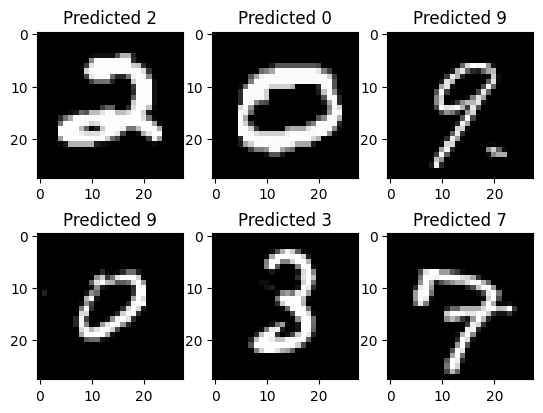

In [22]:
plt.figure()
f, axarr = plt.subplots(2, 3)
counter = 0
for i in range(2):
    for j in range(3):
        axarr[i][j].imshow(imgs[counter].squeeze(), cmap="gray")
        axarr[i][j].set_title(f"Predicted {labels[counter]}")
        counter += 1

In [23]:
submission_df = pd.DataFrame(list(zip(ids, labels)),
               columns =["ImageId", "Label"])
submission_df.to_csv("submission.csv", index=False)
submission_df.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3
